In [3]:
import torch
import torchaudio
import matplotlib.pyplot as plt

def preemphasis(x, alpha=0.97):
    # x: (T,) float32
    return torch.cat([x[:1], x[1:] - alpha * x[:-1]])

def praatish_spectrogram(
    wav, sr,
    win_length_ms=5.0,
    hop_length_ms=1.0,
    n_fft=None,
    preemph=0.97,
    dyn_range_db=70.0,
    max_freq=None,
):
    wav = wav.float().contiguous()
    wav = preemphasis(wav, preemph)

    win_length = int(sr * win_length_ms / 1000.0)
    hop_length = int(sr * hop_length_ms / 1000.0)
    if n_fft is None:
        # next pow2 >= win_length for efficient FFT
        n_fft = 1 << (win_length - 1).bit_length()

    # Gaussian window (sigma tuned; tweak if you want sharper/softer)
    # rule of thumb: sigma ~ win_length/6 gives a nice bell
    sigma = win_length / 6.0
    window = torch.signal.windows.gaussian(win_length, std=sigma)


    X = torch.stft(
        wav, n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
        center=True,
        return_complex=True
    )
    P = (X.abs() ** 2)  # power
    S_db = 10.0 * torch.log10(P + 1e-12)

    # Limit frequency range if desired
    freqs = torch.linspace(0, sr / 2, P.shape[0])
    if max_freq is not None:
        keep = freqs <= max_freq
        S_db = S_db[keep]
        freqs = freqs[keep]

    # Clip dynamic range relative to max
    vmax = S_db.max().item()
    vmin = vmax - dyn_range_db
    S_db = torch.clamp(S_db, min=vmin, max=vmax)

    return S_db.cpu().numpy(), freqs.cpu().numpy(), hop_length / sr, vmin, vmax

def plot_spec(S_db, freqs, hop_s, vmin, vmax):
    plt.figure(figsize=(10, 4))
    extent = [0, S_db.shape[1] * hop_s, freqs[0], freqs[-1]]
    plt.imshow(S_db, origin="lower", aspect="auto",
               interpolation="nearest", extent=extent,
               vmin=vmin, vmax=vmax)
    plt.ylabel("Hz")
    plt.xlabel("s")
    plt.tight_layout()
    plt.show()


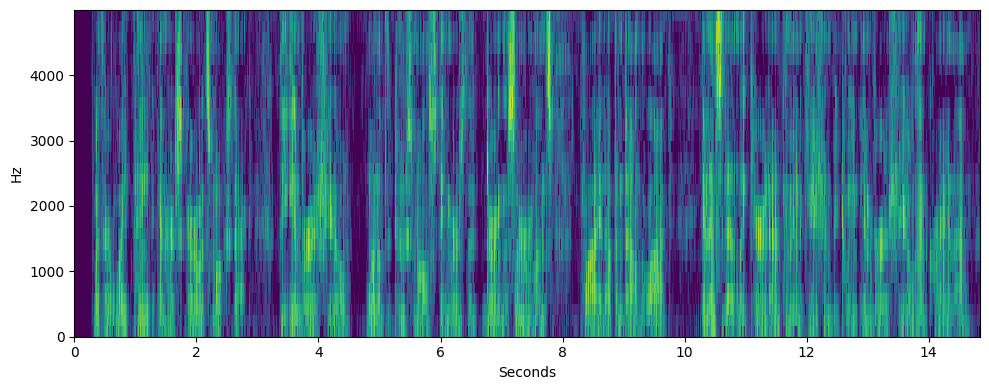

In [4]:
import librosa
import torch
import matplotlib.pyplot as plt

# ---------- Helper functions (as before, with gaussian fix) ----------

def preemphasis(x, alpha=0.97):
    return torch.cat([x[:1], x[1:] - alpha * x[:-1]])

def praatish_spectrogram(
    wav, sr,
    win_length_ms=5.0,
    hop_length_ms=1.0,
    n_fft=None,
    preemph=0.97,
    dyn_range_db=70.0,
    max_freq=None,
):
    wav = wav.float().contiguous()
    wav = preemphasis(wav, preemph)

    win_length = int(sr * win_length_ms / 1000.0)
    hop_length = int(sr * hop_length_ms / 1000.0)
    if n_fft is None:
        n_fft = 1 << (win_length - 1).bit_length()

    # Gaussian window (Praat-like)
    sigma = win_length / 6.0
    window = torch.signal.windows.gaussian(win_length, std=sigma)

    X = torch.stft(
        wav,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
        center=True,
        return_complex=True
    )

    P = X.abs().pow(2)
    S_db = 10.0 * torch.log10(P + 1e-12)

    freqs = torch.linspace(0, sr / 2, S_db.shape[0])
    if max_freq is not None:
        keep = freqs <= max_freq
        S_db = S_db[keep]
        freqs = freqs[keep]

    vmax = S_db.max().item()
    vmin = vmax - dyn_range_db
    S_db = torch.clamp(S_db, min=vmin, max=vmax)

    return S_db.cpu().numpy(), freqs.cpu().numpy(), hop_length / sr, vmin, vmax

def plot_spec(S_db, freqs, hop_s, vmin, vmax):
    plt.figure(figsize=(10, 4))
    extent = [0, S_db.shape[1] * hop_s, freqs[0], freqs[-1]]
    plt.imshow(
        S_db,
        origin="lower",
        aspect="auto",
        interpolation="nearest",
        extent=extent,
        vmin=vmin,
        vmax=vmax,
    )
    plt.ylabel("Hz")
    plt.xlabel("Seconds")
    plt.tight_layout()
    plt.show()

# ---------- Load a speech sample ----------

wav, sr = librosa.load(
    librosa.ex("libri1"),  # speech, not music
    sr=None,
    mono=True
)

wav_t = torch.from_numpy(wav)

# ---------- Compute & plot spectrogram ----------

S_db, freqs, hop_s, vmin, vmax = praatish_spectrogram(
    wav=wav_t,
    sr=sr,
    win_length_ms=5.0,   # phone-scale detail
    hop_length_ms=1.0,
    dyn_range_db=70.0,
    max_freq=5000.0
)

plot_spec(S_db, freqs, hop_s, vmin, vmax)
